## Compare 1DCNN & LSTM via sin wave prediction
サイン波の予測で，1D-CNNと，LSTMの精度を比較

In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten

import tensorflow.keras.callbacks as callbacks

import os
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import plotly
import seaborn as sns

In [2]:
plotly.offline.init_notebook_mode(connected=False)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid", {'grid.linestyle': '--'})
dfstyle = [dict(selector="th", props=[('font-size', '14px')]), dict(selector="td", props=[('font-size', '16px')])]

In [3]:
def sin(x, T=300):
    return np.sin(2.0 * np.pi * x / T)

In [4]:
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

In [5]:
def make_dataset(raw_data, n_prev=100, maxlen=25):
    data, target  = [], []
    
    for i in range(len(raw_data) - maxlen):
        data.append(raw_data[i:i+maxlen])
        target.append(raw_data[i+maxlen])
        
    reshaped_data = np.array(data).reshape(len(data), maxlen, 1)
    reshaped_target = np.array(target).reshape(len(target), 1)
    
    return reshaped_data, reshaped_target

# 1D-CNN

### Generate Noise sin Wave
ノイズ入りサイン波の生成

In [6]:
function = toy_problem(T=300)

### Data Shaping for 1D-CNN
1DCNN 用にデータ整形

In [7]:
data, label = make_dataset(function, maxlen=50)
print(data.shape)

(551, 50, 1)


### Define the model
#### モデル定義

In [8]:
inputs = Input(shape=(50, 1))

x = Conv1D(30, 2, padding='same', activation='relu')(inputs)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Conv1D(10, 2, padding='same', activation='relu')(x)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Flatten()(x)
x = Dense(300, activation='relu')(x)
x = Dense(1, activation='tanh')(x)

model = Model(inputs, outputs=x)

optimizer = Adam(lr=1e-3)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [9]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [10]:
model.fit(data, label,
         batch_size=64, epochs=1000,
          validation_split=0.2, callbacks=[early_stopping]
         )

Epoch 1/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.2813 - val_loss: 0.0588
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0867 - val_loss: 0.0239
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0544 - val_loss: 0.0045
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0313 - val_loss: 0.0049
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0039
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0053
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 10/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0045


## Prediction | Training data

In [11]:
predicted  = model.predict(data)

## Prediction | Future data 

In [12]:
future_test = data[-1].T
time_length = future_test.shape[1]
future_result = np.empty((0))

In [13]:
for step in range(400):
    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)
    
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    
    future_result = np.append(future_result, batch_predict)

## Plot with Seaborn 

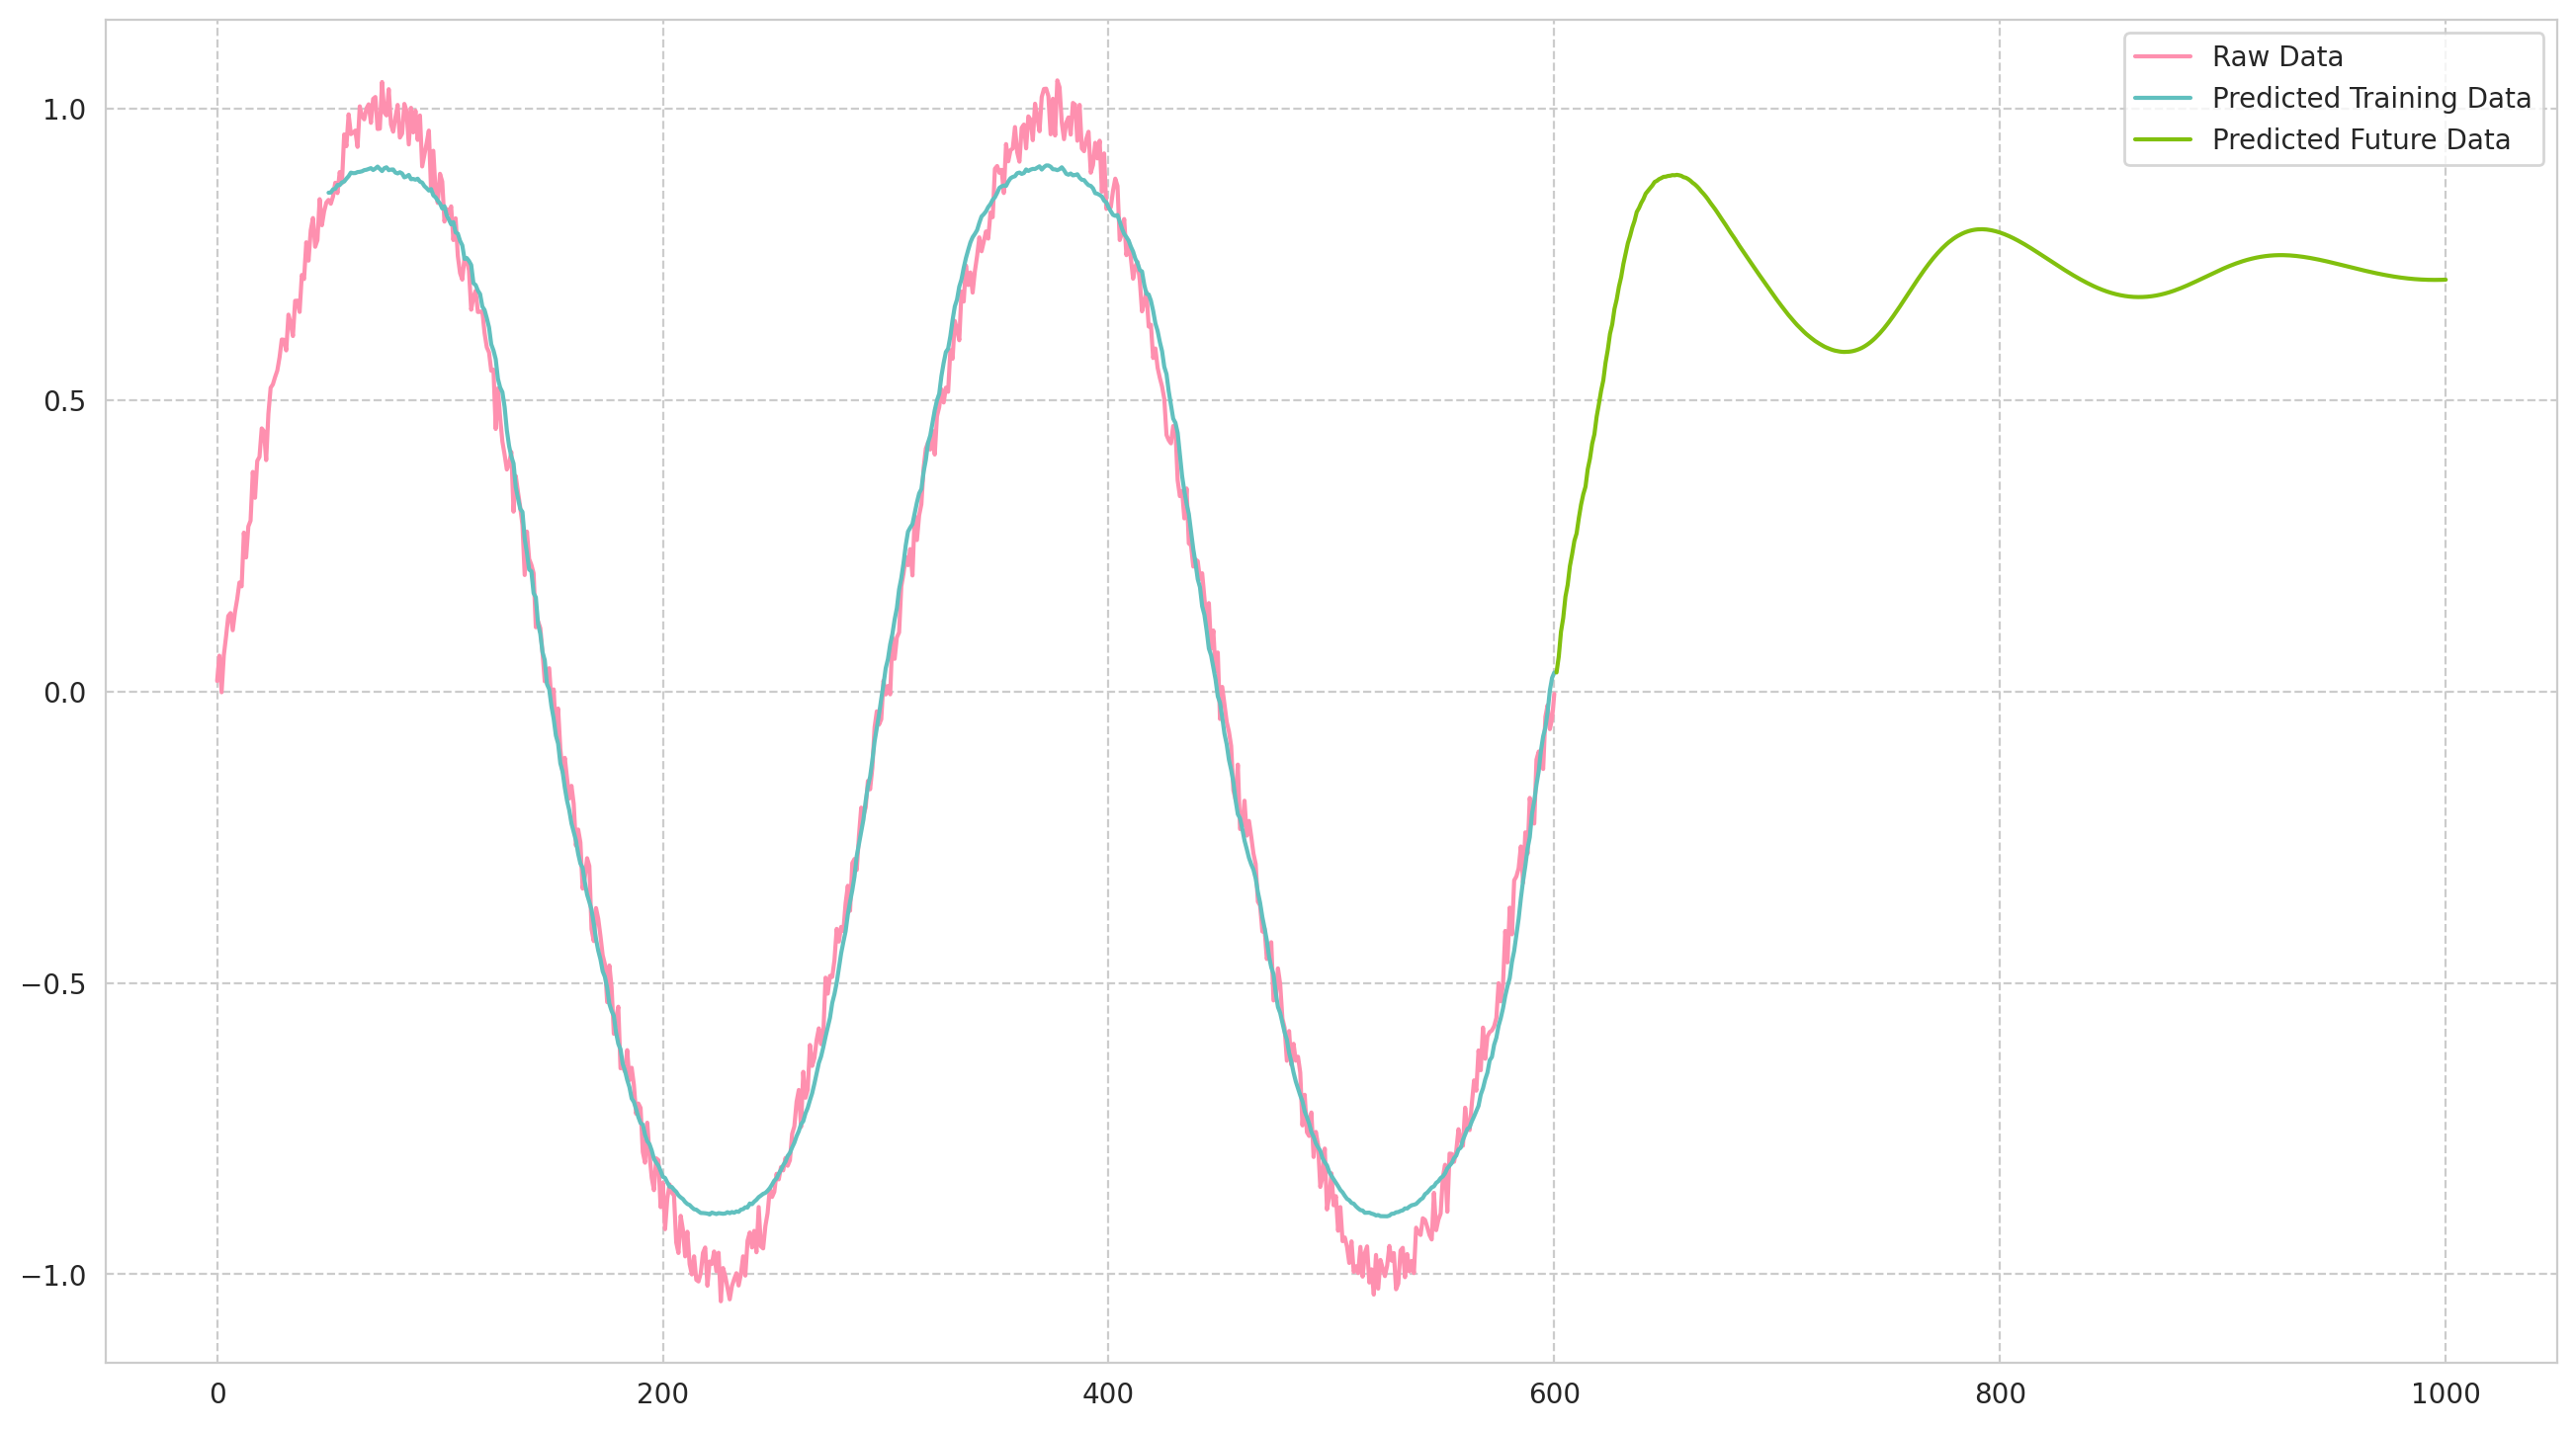

In [14]:
fig = plt.figure(figsize=(16, 9), dpi=200)

sns.lineplot(
    color="#fe90af",
    data=function,
    label="Raw Data"
)

sns.lineplot(
    color="#61c0bf",
    x=np.arange(50, len(predicted)+50),
    y=predicted.reshape(-1),
    label="Predicted Training Data"
)

sns.lineplot(
    color="#81c00e",
    x=np.arange(0+len(function), len(function)+len(future_result)),
    y=future_result.reshape(-1),
    label="Predicted Future Data"
)

# Compare LSTM model

### Define LSTM model

In [15]:
length_of_sequence = data.shape[1]
in_out_neurons = 1
n_hidden = 300

lstm = Sequential()
lstm.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
lstm.add(Dense(in_out_neurons))
lstm.add(Activation('linear'))
optimizer = Adam(lr=1e-3)
lstm.compile(loss="mean_squared_error", optimizer=optimizer)

In [16]:
lstm.fit(data, label,
        batch_size=100, epochs=200,
        validation_split=0.2, callbacks=[early_stopping]
        )

Epoch 1/200
5/5 [==============================] - 0s 58ms/step - loss: 0.2415 - val_loss: 0.0202
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0211 - val_loss: 0.0091
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0153 - val_loss: 0.0191
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 6/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 10/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/200
5/5 [=

## Compare LSTM

In [17]:
lstm_predicted = lstm.predict(data)

In [18]:
lstm_future_test = data[-1].T
lstm_time_length = lstm_future_test.shape[1]
lstm_future_result = np.empty((0))
for step in range(400):
    test_data= np.reshape(lstm_future_test, (1, lstm_time_length, 1))
    batch_predict = lstm.predict(test_data)
    
    lstm_future_test = np.delete(lstm_future_test, 0)
    lstm_future_test = np.append(lstm_future_test, batch_predict)
    
    lstm_future_result = np.append(lstm_future_result, batch_predict)

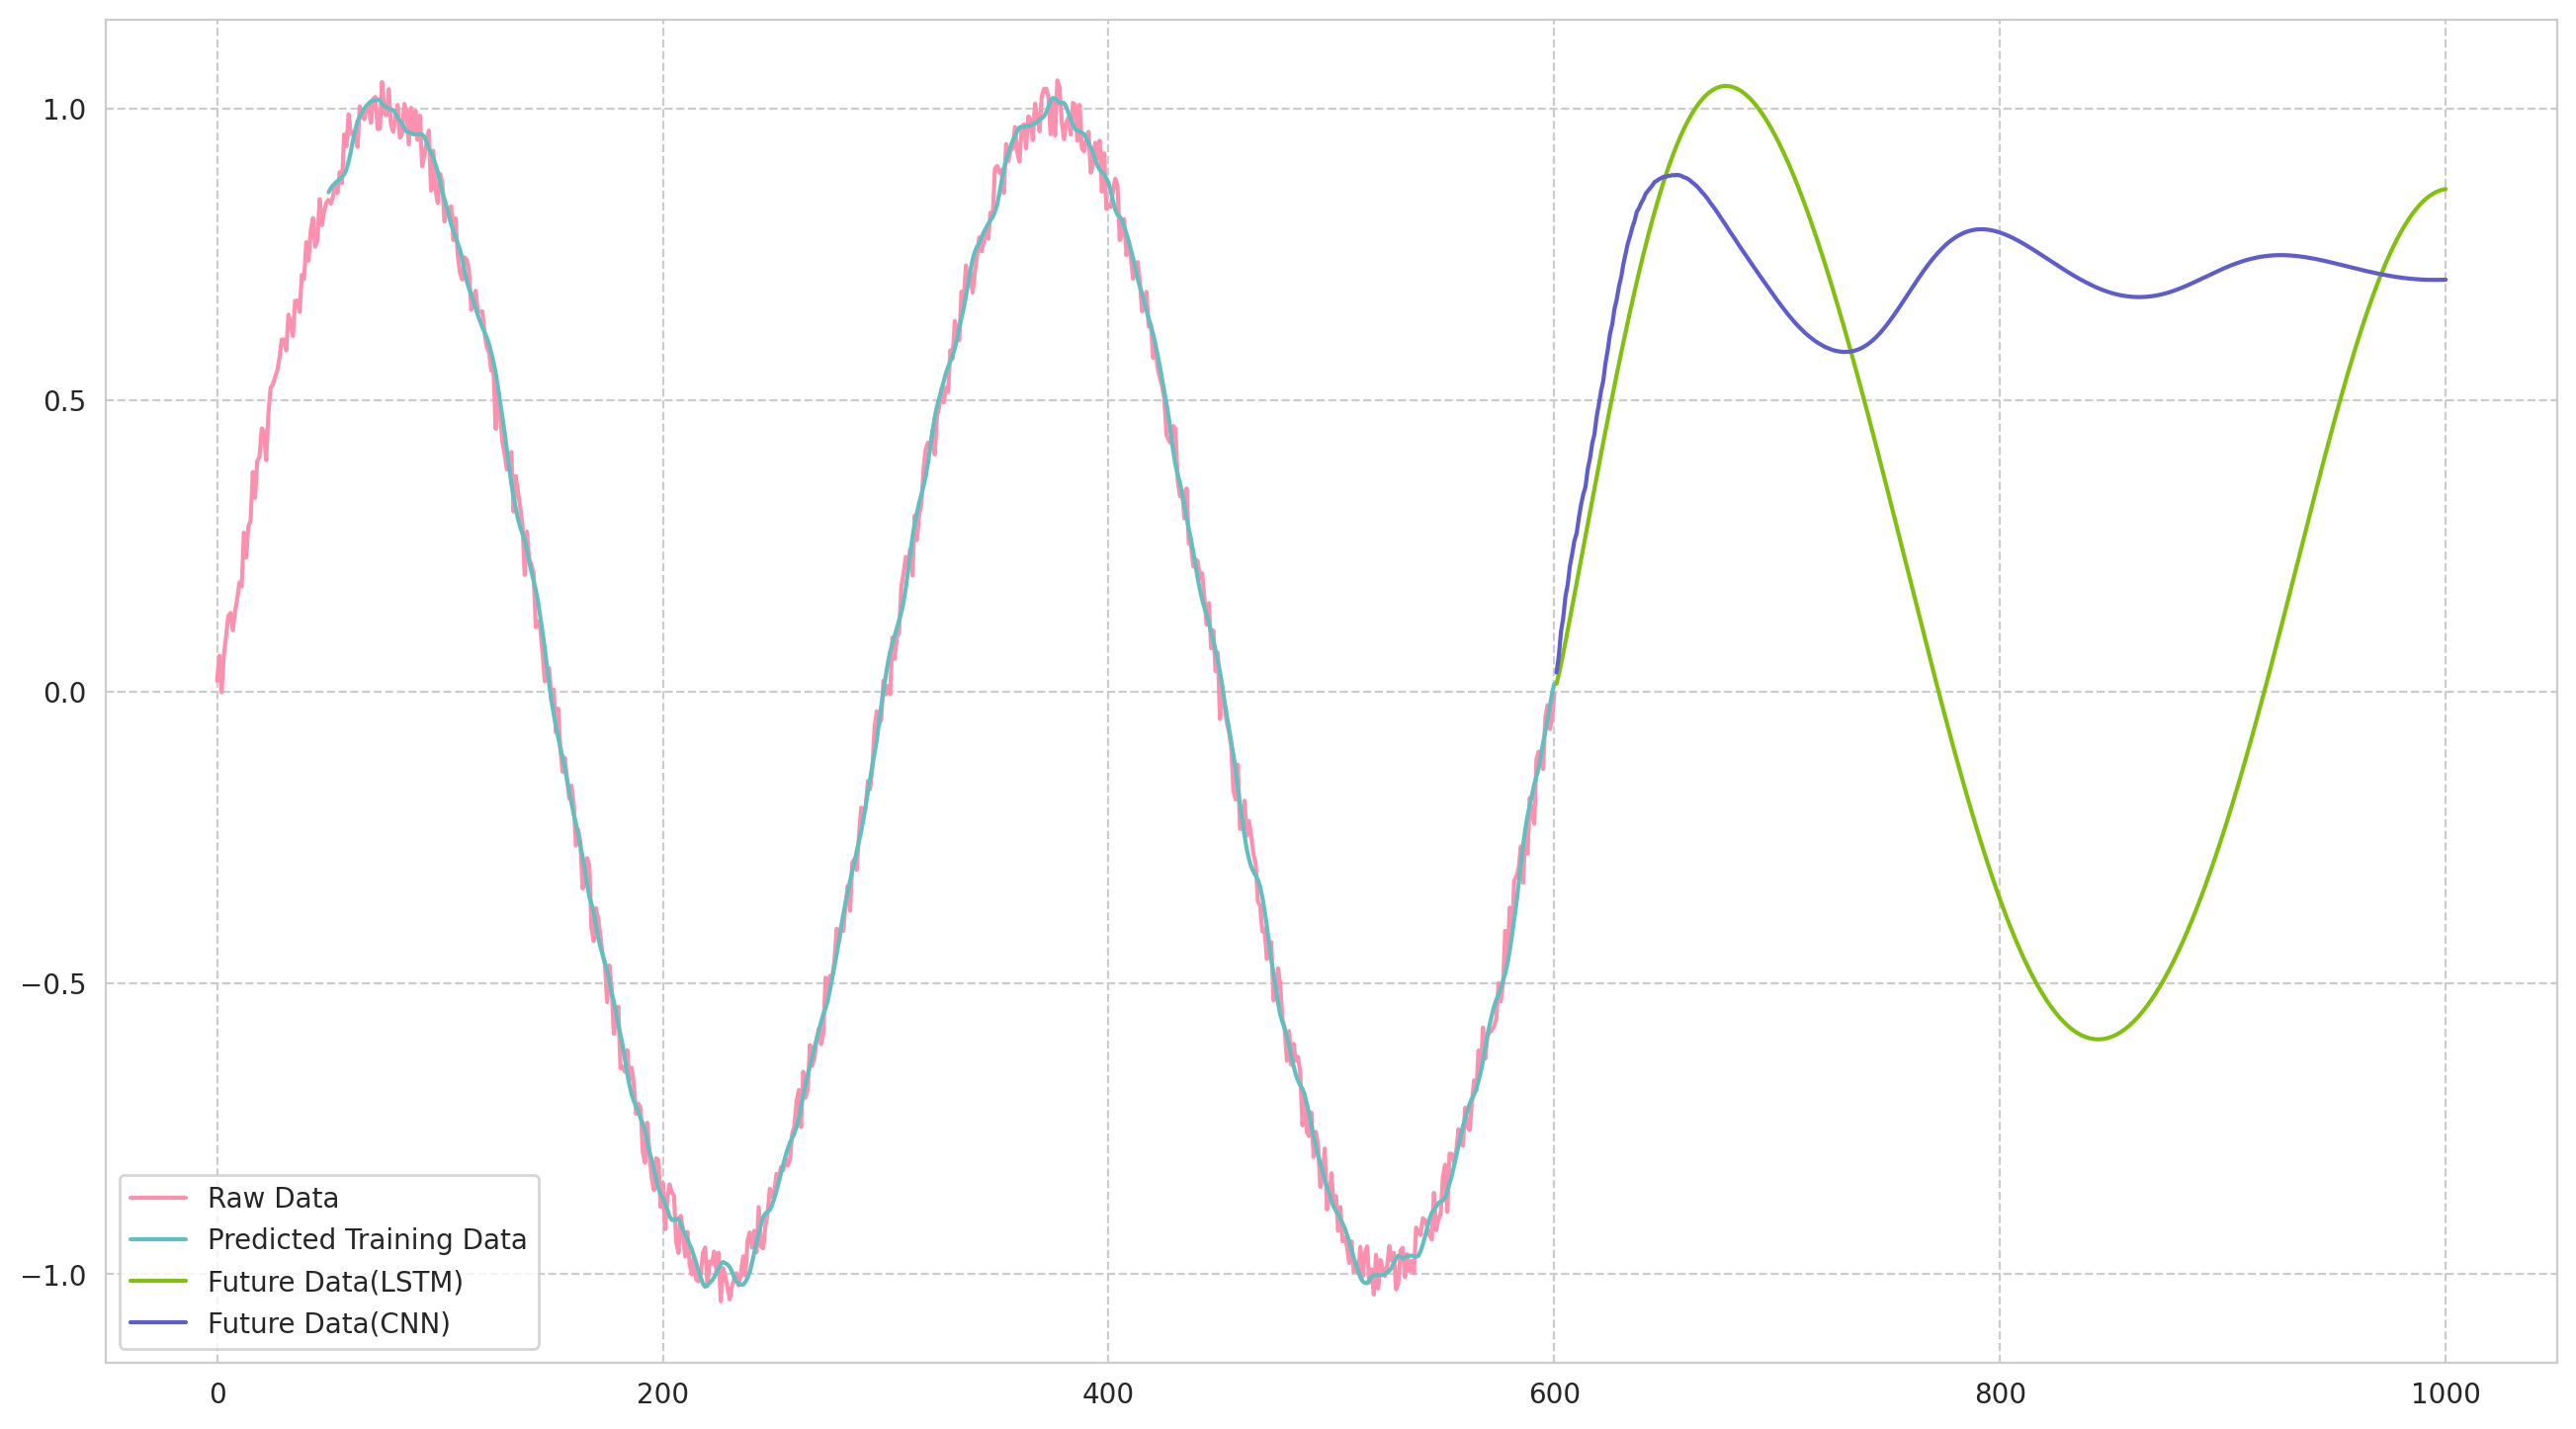

In [19]:
fig2 = plt.figure(figsize=(16, 9), dpi=200)

sns.lineplot(
    color="#fe90af",
    data=function,
    label="Raw Data"
)

sns.lineplot(
    color="#61c0bf",
    x=np.arange(50, len(lstm_predicted)+50),
    y=lstm_predicted.reshape(-1),
    label="Predicted Training Data"
)

sns.lineplot(
    color="#81c00e",
    x=np.arange(0+len(function), len(function)+len(lstm_future_result)),
    y=lstm_future_result.reshape(-1),
    label="Future Data(LSTM)"
)

sns.lineplot(
    color="#5f5cce",
    x=np.arange(0+len(function), len(function)+len(future_result)),
    y=future_result.reshape(-1),
    label="Future Data(CNN)"
)

## More long time
より長い周期で予測してみる

### Predict CNN

In [20]:
cnn_future_test = data[-1].T
cnn_time_length = cnn_future_test.shape[1]
cnn_future_result = np.empty((0))
for step in range(2000):
    test_data= np.reshape(cnn_future_test, (1, cnn_time_length, 1))
    batch_predict = model.predict(test_data)
    
    cnn_future_test = np.delete(cnn_future_test, 0)
    cnn_future_test = np.append(cnn_future_test, batch_predict)
    
    cnn_future_result = np.append(cnn_future_result, batch_predict)

### Predict LSTM

In [21]:
poc_lstm_future_test = data[-1].T
poc_lstm_time_length = poc_lstm_future_test.shape[1]
poc_lstm_future_result = np.empty((0))
for step in range(2000):
    test_data= np.reshape(poc_lstm_future_test, (1, poc_lstm_time_length, 1))
    batch_predict = lstm.predict(test_data)
    
    poc_lstm_future_test = np.delete(poc_lstm_future_test, 0)
    poc_lstm_future_test = np.append(poc_lstm_future_test, batch_predict)
    
    poc_lstm_future_result = np.append(poc_lstm_future_result, batch_predict)

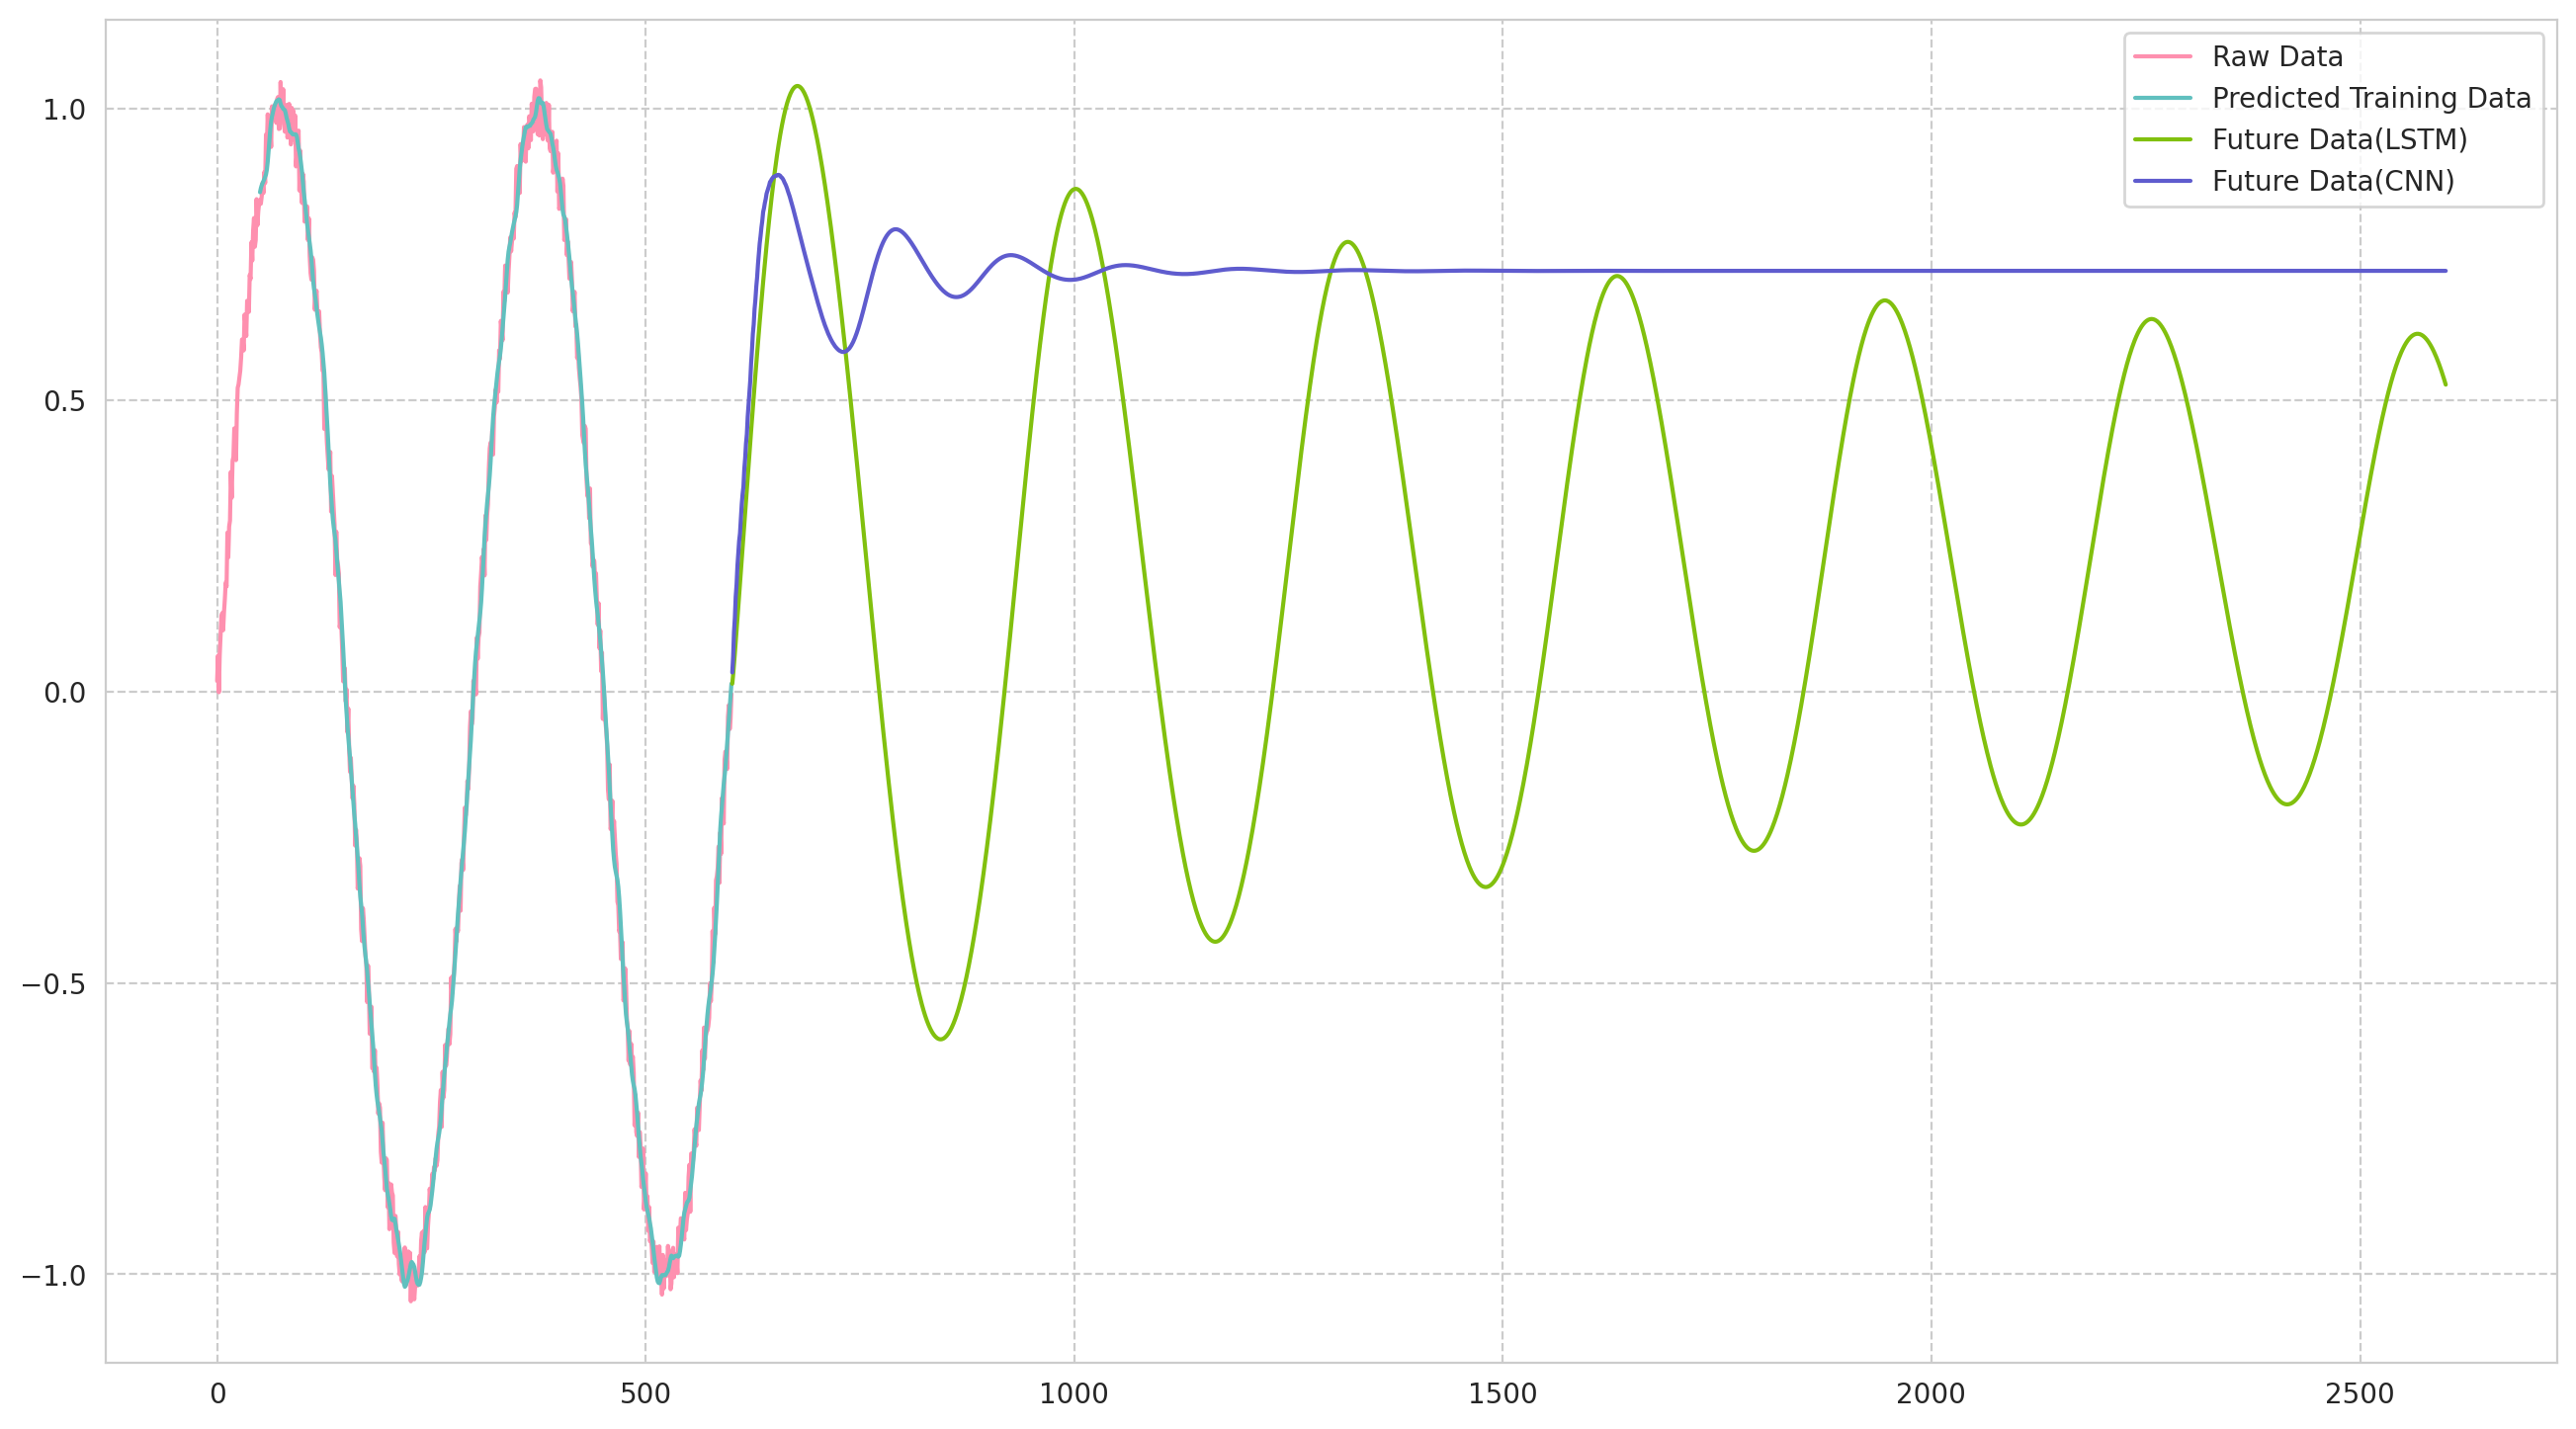

In [22]:
fig3 = plt.figure(figsize=(16, 9), dpi=200)

sns.lineplot(
    color="#fe90af",
    data=function,
    label="Raw Data"
)

sns.lineplot(
    color="#61c0bf",
    x=np.arange(50, len(lstm_predicted)+50),
    y=lstm_predicted.reshape(-1),
    label="Predicted Training Data"
)

sns.lineplot(
    color="#81c00e",
    x=np.arange(0+len(function), len(function)+len(poc_lstm_future_result)),
    y=poc_lstm_future_result.reshape(-1),
    label="Future Data(LSTM)"
)

sns.lineplot(
    color="#5f5cce",
    x=np.arange(0+len(function), len(function)+len(cnn_future_result)),
    y=cnn_future_result.reshape(-1),
    label="Future Data(CNN)"
)

## Use generated Sin wave for prediction

In [23]:
long_function = toy_problem(T=700)
long_data, long_label = make_dataset(long_function, maxlen=50)
print(long_data.shape)

(1351, 50, 1)


In [24]:
long_cnn_predicted = model.predict(long_data)
long_lstm_predicted = lstm.predict(long_data)

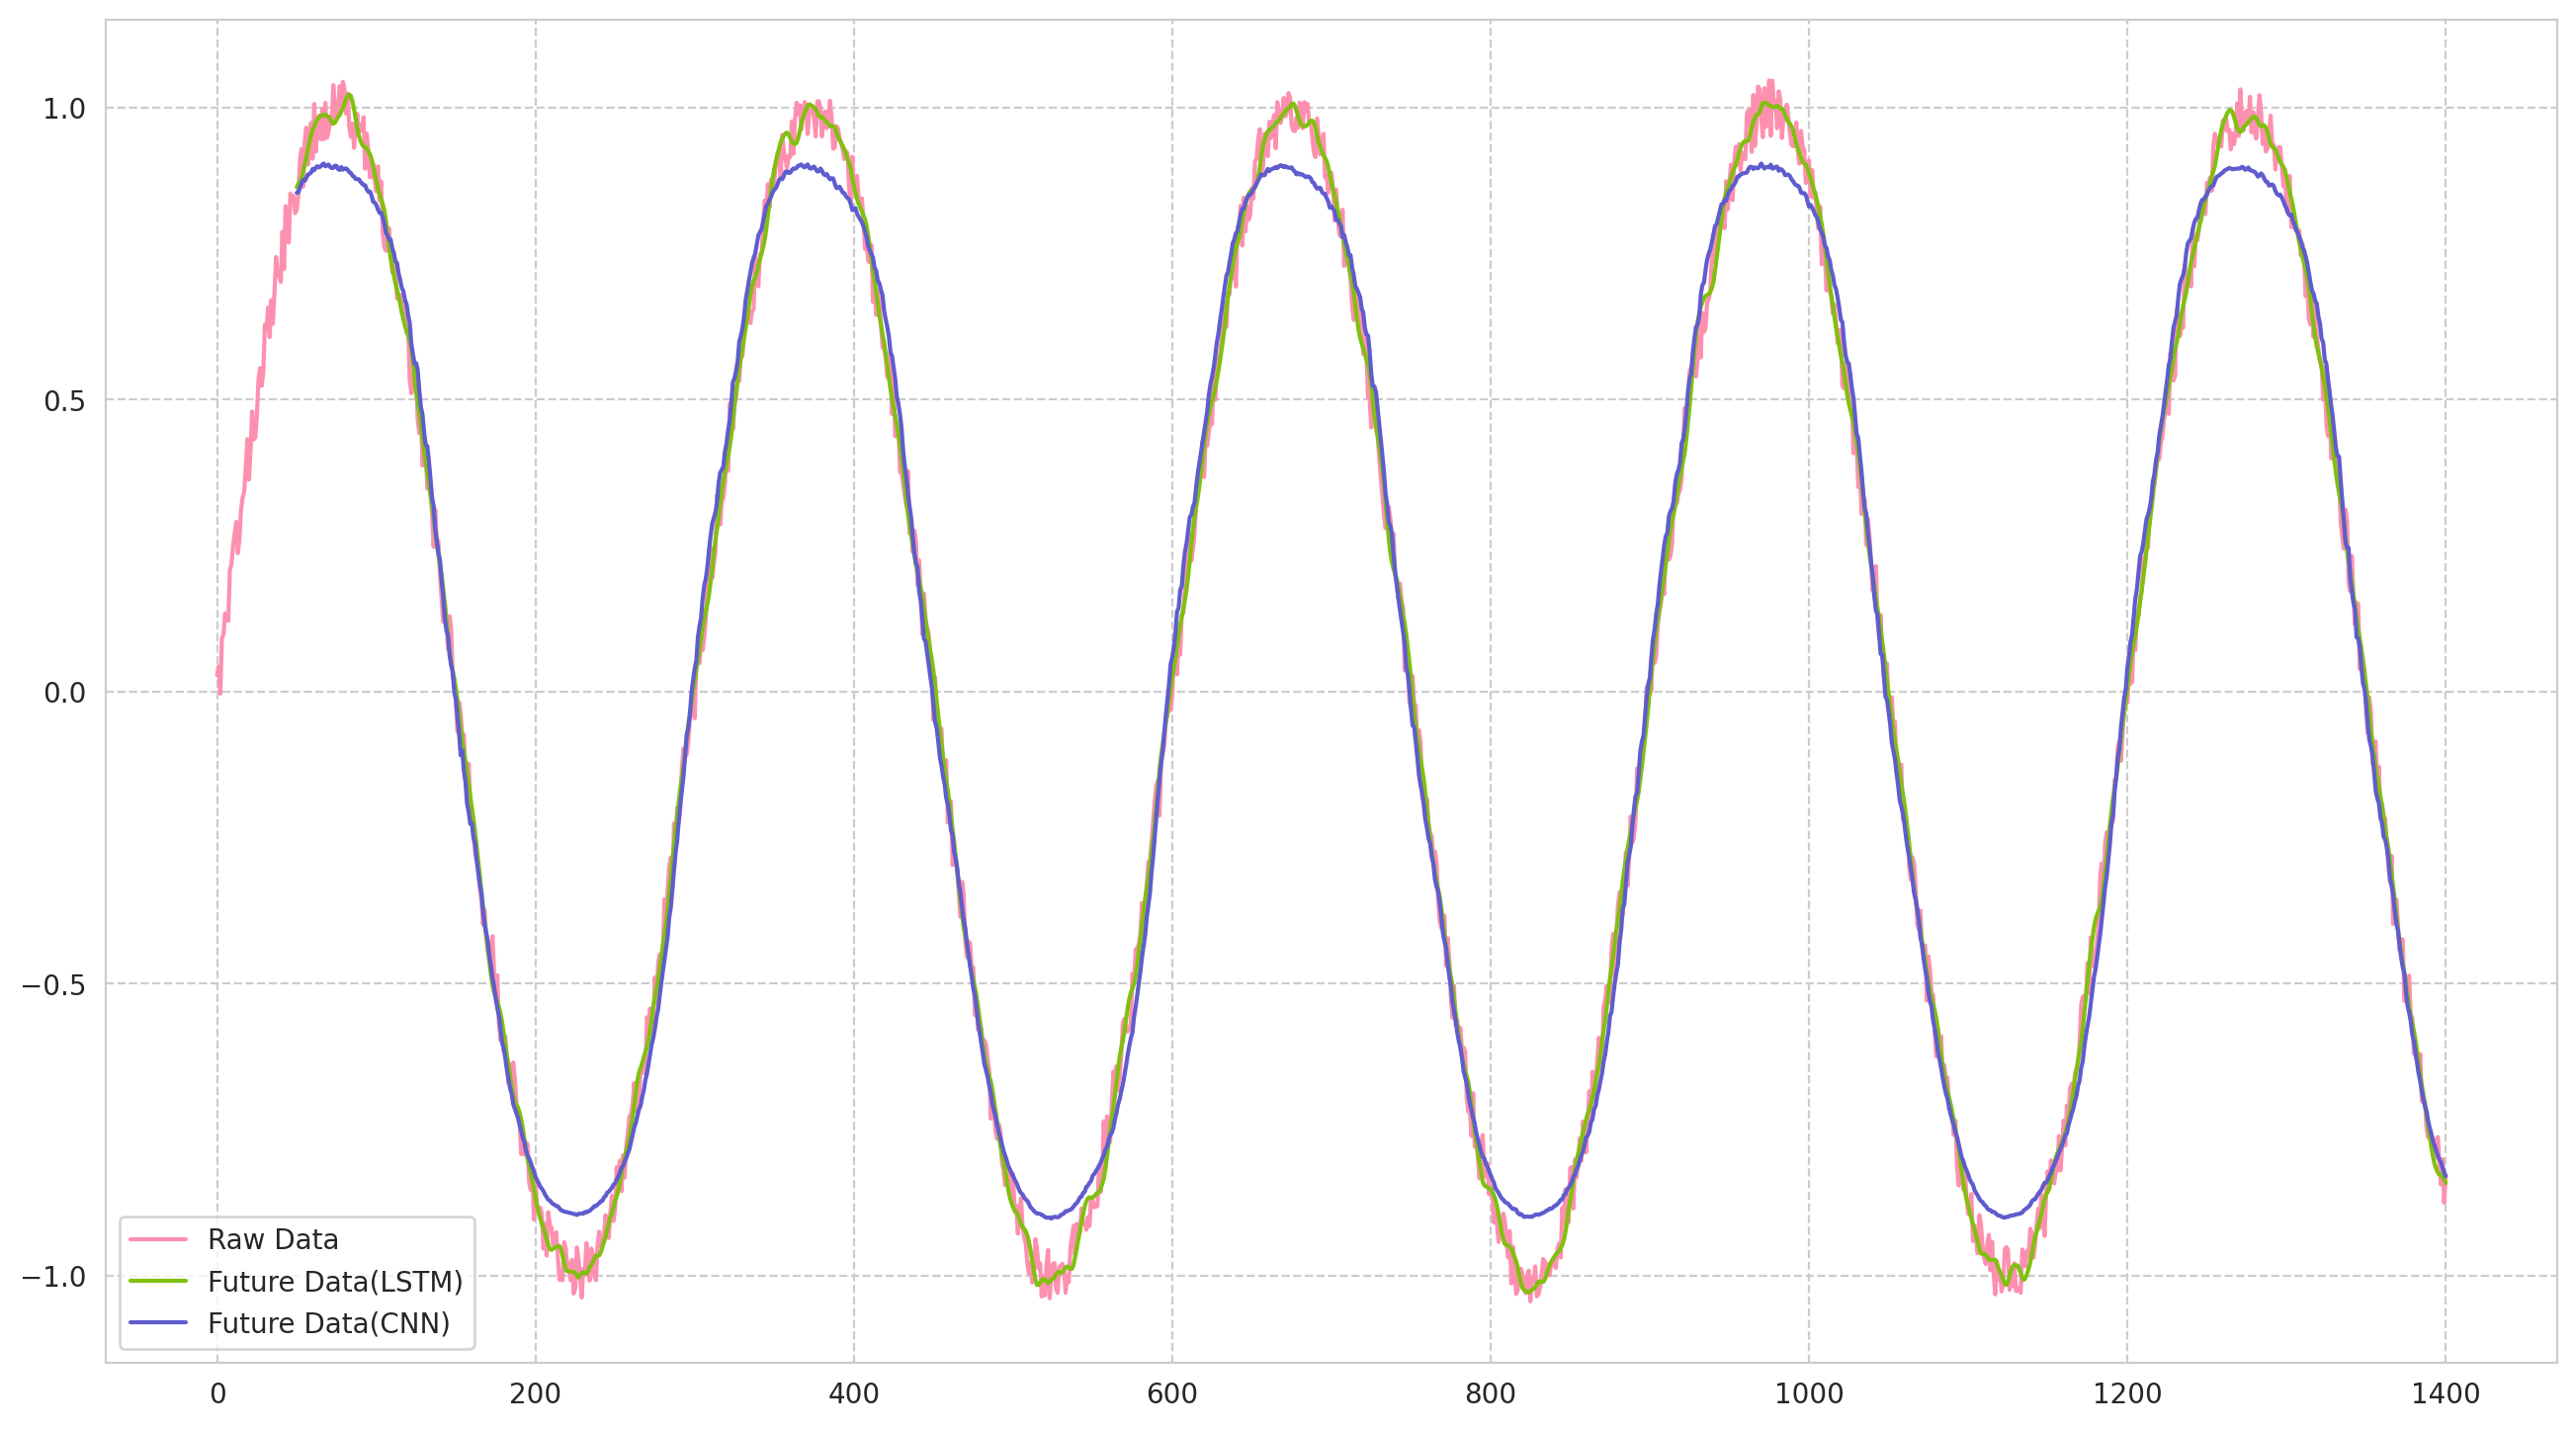

In [25]:
fig4 = plt.figure(figsize=(16, 9), dpi=200)

sns.lineplot(
    color="#fe90af",
    data=long_function,
    label="Raw Data"
)

sns.lineplot(
    color="#81c00e",
    x=np.arange(50, len(long_lstm_predicted) + 50),
    y=long_lstm_predicted.reshape(-1),
    label="Future Data(LSTM)"
)

sns.lineplot(
    color="#5f5cce",
    x=np.arange(50, len(long_cnn_predicted) + 50),
    y=long_cnn_predicted.reshape(-1),
    label="Future Data(CNN)"
)

#### Compare use MSE
平均２乗誤差での評価

In [26]:
MSE = {}
MSE['lstm']  = np.sum((long_function[50:] - long_lstm_predicted.reshape(-1))**2) / len(long_lstm_predicted)
MSE['cnn'] = np.sum((long_function[50:] - long_cnn_predicted.reshape(-1))**2) / len(long_cnn_predicted)

In [27]:
pd.DataFrame(MSE, index=['MSE']).style.set_table_styles(dfstyle)

# Learning long sequence
予測する情報を，1点ではなく10点にしてみる

In [28]:
# 複数シーケンスラベルを用いることができる関数
def make_dataset2(raw_data, n_prev=100, maxlen=25, label_length=1):
    data, target  = [], []
    
    for i in range(len(raw_data) - maxlen - (label_length)):
        data.append(raw_data[i:i+maxlen])
        target.append(raw_data[i+maxlen : i+maxlen+label_length])
        
    reshaped_data = np.array(data).reshape(len(data), maxlen, 1)
    reshaped_target = np.array(target).reshape(len(target), label_length)
    
    return reshaped_data, reshaped_target

In [29]:
multiple_data, multiple_label = make_dataset2(function, maxlen=50, label_length=10)
print(multiple_data.shape)
print(multiple_label.shape)

(541, 50, 1)
(541, 10)


### LSTM

In [30]:
length_of_sequence = multiple_data.shape[1]
in_out_neurons = 1
n_hidden = 300

multiple_lstm = Sequential()
multiple_lstm.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
multiple_lstm.add(Dense(10))
multiple_lstm.add(Activation('linear'))
optimizer = Adam(lr=1e-3)
multiple_lstm.compile(loss="mean_squared_error", optimizer=optimizer)

In [31]:
multiple_lstm.fit(multiple_data, multiple_label,
        batch_size=100, epochs=200,
        validation_split=0.2, callbacks=[early_stopping]
        )

Epoch 1/200
5/5 [==============================] - 0s 58ms/step - loss: 0.3261 - val_loss: 0.0857
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.1027 - val_loss: 0.0471
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0470 - val_loss: 0.0262
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0214 - val_loss: 0.0324
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0155 - val_loss: 0.0468
Epoch 6/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0048
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 10/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 11/200
5/5 [=

### 1D-CNN

In [32]:
inputs = Input(shape=(50, 1))

x = Conv1D(30, 2, padding='same', activation='relu')(inputs)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Conv1D(10, 2, padding='same', activation='relu')(x)
x = MaxPool1D(pool_size=2, padding='same')(x)

x = Flatten()(x)
x = Dense(300, activation='relu')(x)
x = Dense(10, activation='tanh')(x)

multiple_cnn = Model(inputs, outputs=x)

optimizer = Adam(lr=1e-3)
multiple_cnn.compile(loss="mean_squared_error", optimizer=optimizer)

In [33]:
multiple_cnn.fit(multiple_data, multiple_label,
         batch_size=64, epochs=1000,
          validation_split=0.2, callbacks=[early_stopping]
         )

Epoch 1/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.4180 - val_loss: 0.4072
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2318 - val_loss: 0.1806
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1199 - val_loss: 0.0693
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0666 - val_loss: 0.0537
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0314 - val_loss: 0.0378
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0191 - val_loss: 0.0217
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0164
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0104
Epoch 10/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 11/1000
7/7 

## Future predict

### 1D-CNN

In [34]:
OUTPUT_LENGTH = 10

In [35]:
long_test = multiple_data[-1].T
long_test_length = long_test.shape[1]
long_cnn_result  = np.empty((0))

for step in range(120):
    long_test_data = np.reshape(long_test, (1,  long_test_length, 1))
    batch_predict = multiple_cnn.predict(long_test_data)
    
    long_test = np.delete(long_test, list(range(OUTPUT_LENGTH)))
    long_test = np.append(long_test, batch_predict)
    
    long_cnn_result = np.append(long_cnn_result, batch_predict)

###  LSTM

In [36]:
long_test = multiple_data[-1].T
long_test_length = long_test.shape[1]
long_result = np.empty((0))
for step in range(120):
    long_test_data = np.reshape(long_test, (1, long_test_length, 1))
    batch_predict = multiple_lstm.predict(long_test_data)
    
    long_test = np.delete(long_test, list(range(OUTPUT_LENGTH)))
    long_test = np.append(long_test, batch_predict)
    
    long_result = np.append(long_result, batch_predict)
    

### Plot

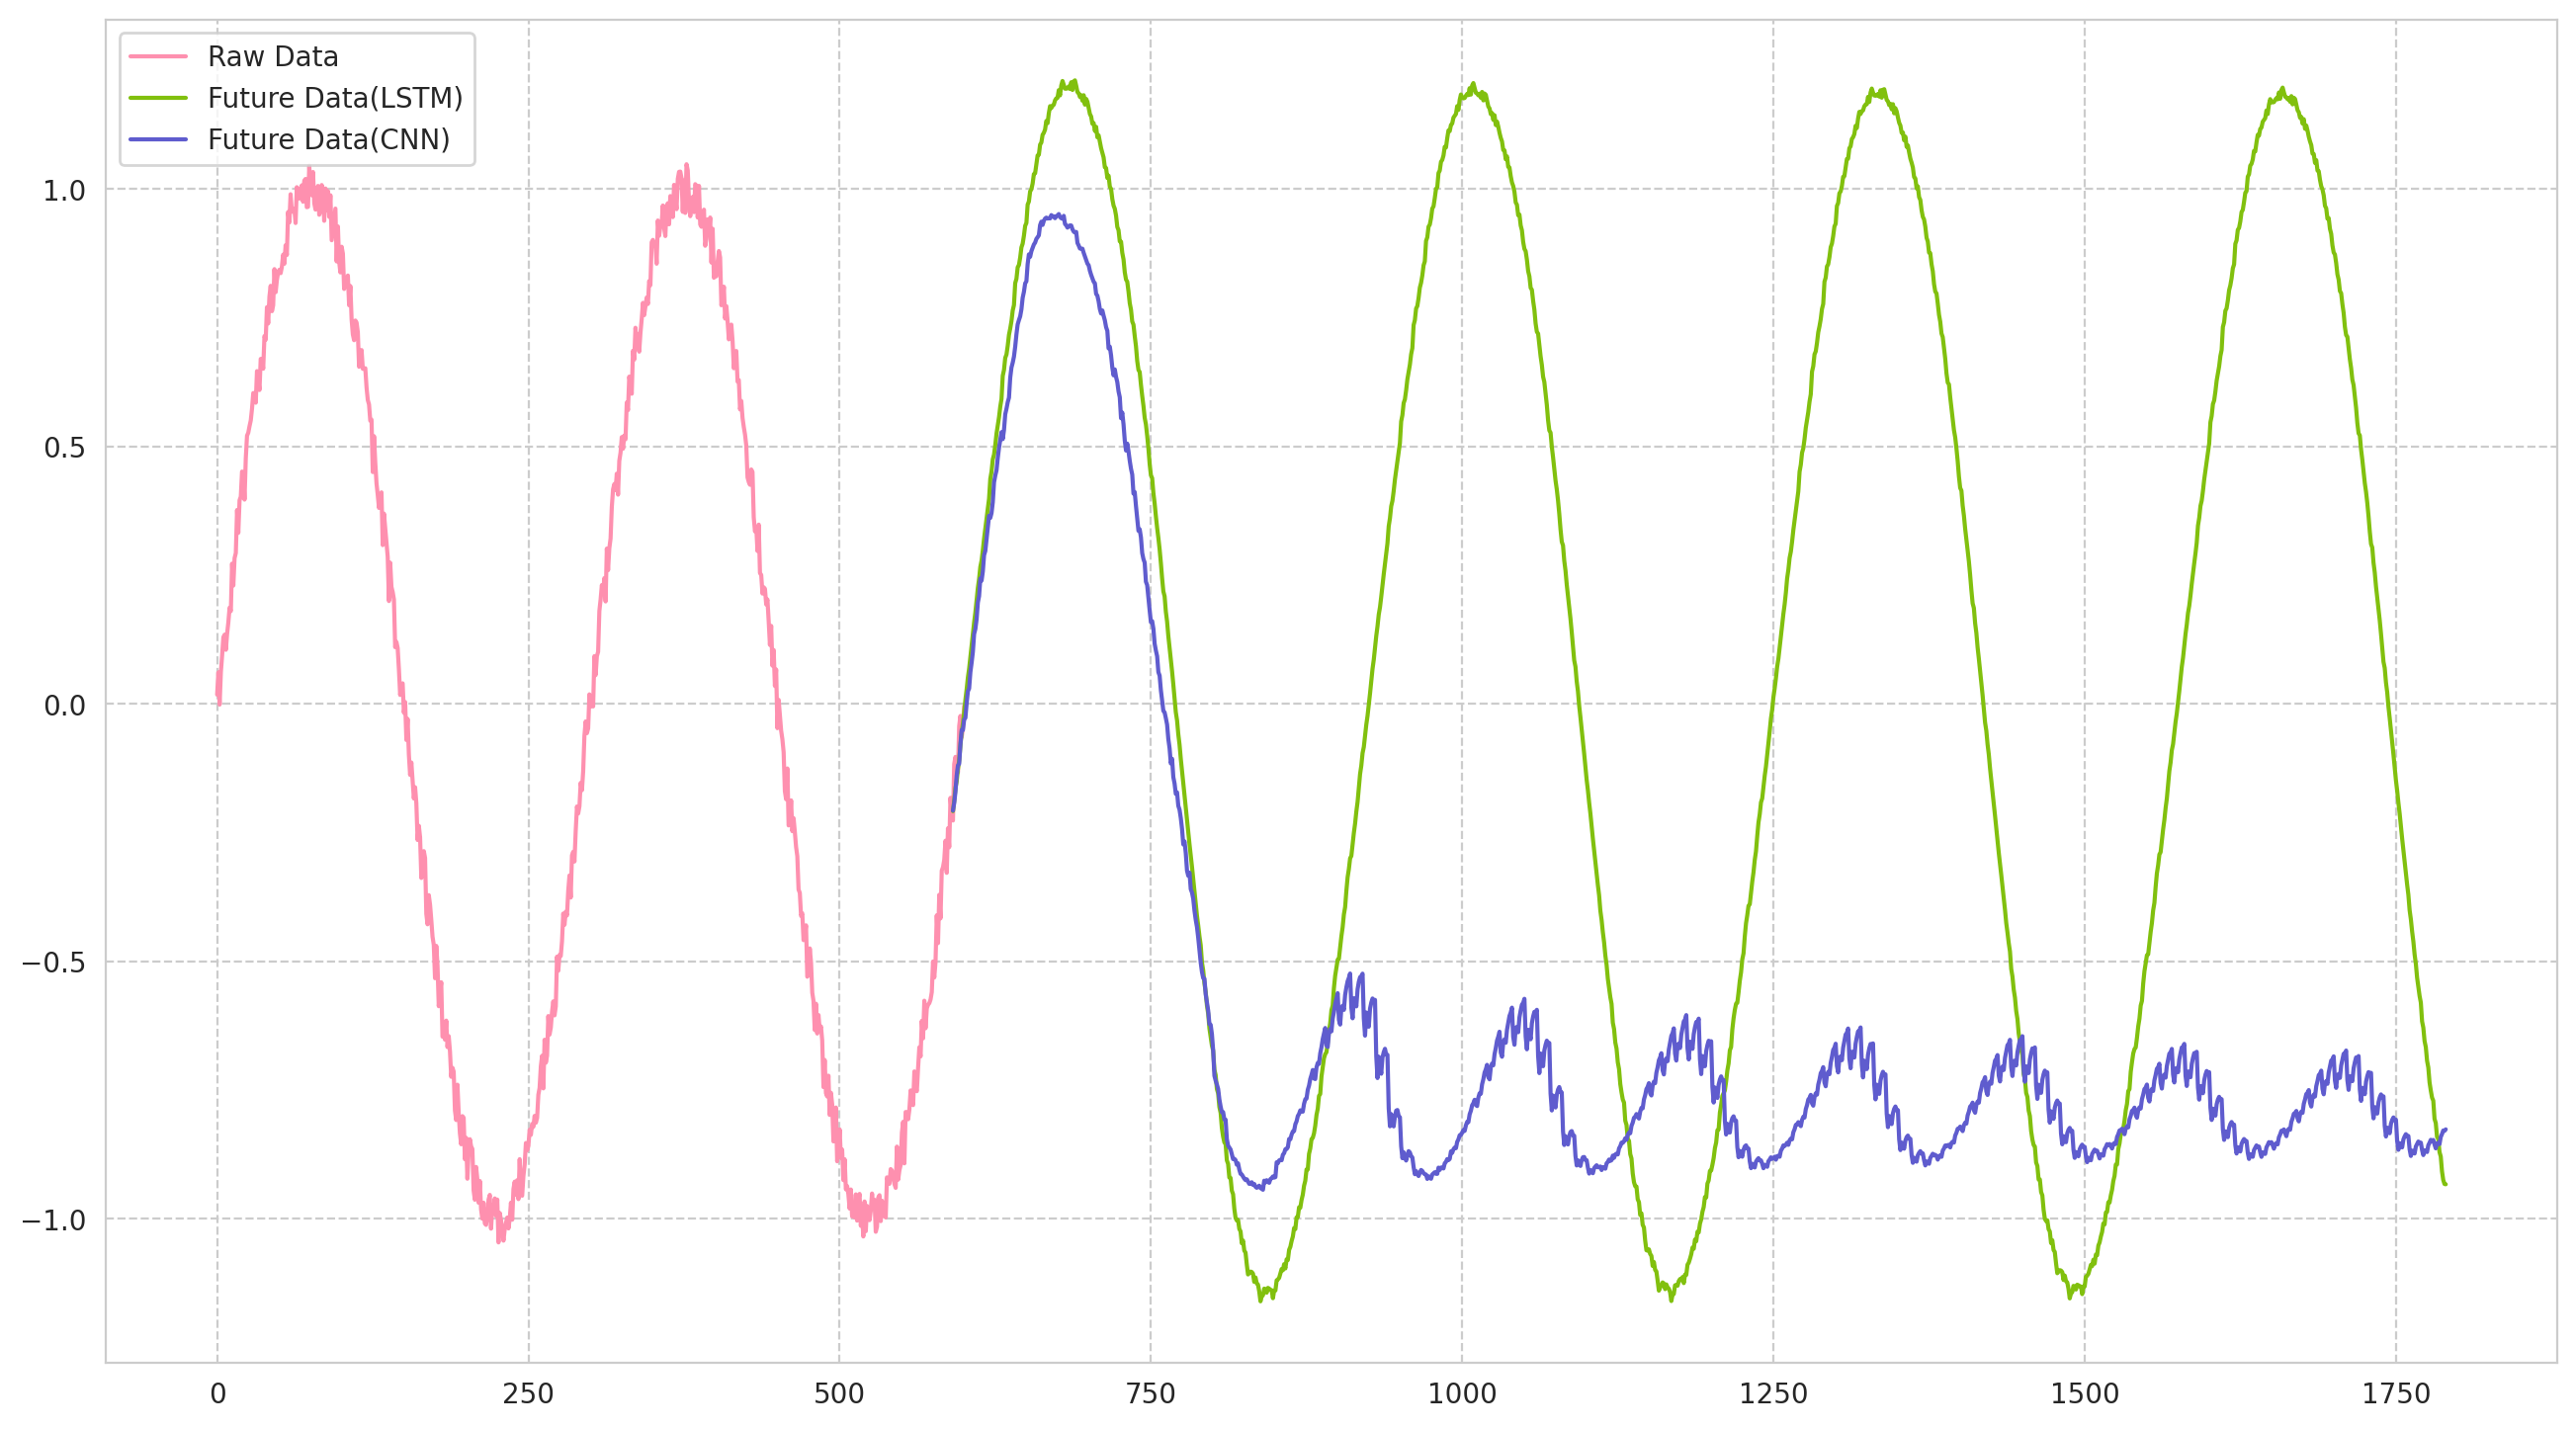

In [37]:
fig4 = plt.figure(figsize=(16, 9), dpi=200)

sns.lineplot(
    color="#fe90af",
    data=function,
    label="Raw Data"
)

sns.lineplot(
    color="#81c00e",
    x=np.arange(0+len(function)-OUTPUT_LENGTH, len(function)+len(long_result) - OUTPUT_LENGTH),
    y=long_result.reshape(-1),
    label="Future Data(LSTM)"
)

sns.lineplot(
    color="#5f5cce",
    x=np.arange(0+len(function)-OUTPUT_LENGTH, len(function)+len(long_cnn_result)-OUTPUT_LENGTH),
    y=long_cnn_result.reshape(-1),
    label="Future Data(CNN)"
)